## Rotten fruit detection

In [32]:
# Mina imports
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random


In [33]:
# Sökvägen till datan
train_data = r"C:\Users\rbs\Documents\GitHub\Rotten-fruit-detection\dataset\train"
test_data = r"C:\Users\rbs\Documents\GitHub\Rotten-fruit-detection\dataset\test"


In [34]:
# Använder vgg16 som min neural network model och hämtar datat "live" från min directory.
train_batches = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
    rescale = 1/255. # Skalar värden mellan 0-1
    ).flow_from_directory(
    directory = train_data,
    target_size = (200, 200), #Defaulten är 224x224, men vill testa lite olika och se skillnaden. 
    classes = ["freshapples", "freshbanana", "rottenapples", "rottenbanana"], # alla mina classer jag använder
    batch_size = 32, # Har experimenterat med flera batch sizes men tycker att 32 blir det bästa
    class_mode = "categorical", # Ger tillbaka one hot encoded labels för classerna
    color_mode = "rgb",
    shuffle=True
    )

test_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input, 
    rescale=1/255.
).flow_from_directory(
    directory= test_data,
    target_size= (200, 200),
    classes = ["freshapples", "freshbanana", "rottenapples", "rottenbanana"],
    batch_size=32,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=False
    )


Found 7840 images belonging to 4 classes.
Found 1907 images belonging to 4 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


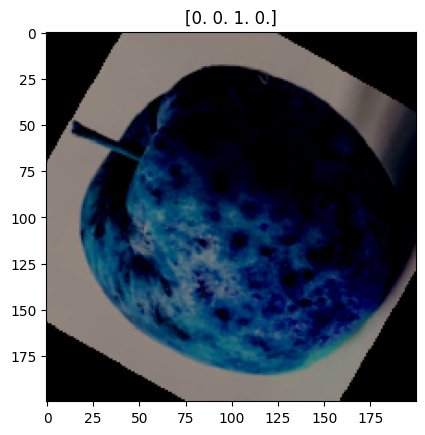

In [37]:
# Få en batch av bilder och labels
x_batch, y_batch = train_batches.next()

# Tar en random bild och batch bara för att kunna kolla på bilderna
random_index = random.randint(0, len(x_batch))
random_image = x_batch[random_index]
random_label = y_batch[random_index]

# Visar bilden
plt.imshow(random_image)
plt.title(random_label)
plt.show()

# 1.0.0.0 = fresh apple
# 0.1.0.0 = fresh banana
# 0.0.1.0 = rotten apple
# 0.0.0.1 = rotten banana
# kan göra det snyggare att skriva texten istället för one hot encode (todo)

In [38]:
# Modellen
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3))) 
model.add(MaxPooling2D((2, 2))) # Hjälpter till med overfittning och minskar onödig data
model.add(BatchNormalization()) # Används för att stabilisera datat bättre
model.add(Dropout(0.25)) # Hjälper också till med overfitting 25% av gammla activations blir random till 0 (vill testa andra värden)
model.add(Conv2D(64, (3, 3), activation='relu')) # Använder 64 filters som används för att leta efter features i bilden, och 3x3 är storleken.
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax')) # Min output på 4 classer.

#evaluating the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 99, 99, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 99, 99, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 48, 48, 64)      

In [39]:
model.fit(train_batches, epochs=7) # Har testat like epochs men 7 verkar funka bra.

Epoch 1/7
245/245 [==============================] - 219s 884ms/step - loss: 0.4816 - accuracy: 0.8268
Epoch 2/7
245/245 [==============================] - 216s 882ms/step - loss: 0.2405 - accuracy: 0.9147
Epoch 3/7
245/245 [==============================] - 217s 885ms/step - loss: 0.1751 - accuracy: 0.9399
Epoch 4/7
245/245 [==============================] - 215s 878ms/step - loss: 0.1455 - accuracy: 0.9476
Epoch 5/7
245/245 [==============================] - 215s 878ms/step - loss: 0.1325 - accuracy: 0.9524
Epoch 6/7
245/245 [==============================] - 215s 877ms/step - loss: 0.1267 - accuracy: 0.9533
Epoch 7/7
245/245 [==============================] - 215s 877ms/step - loss: 0.1542 - accuracy: 0.9469


## Evaluerar modellen

In [40]:
model.evaluate(test_batches, steps= test_batches.samples/test_batches.batch_size)

59/59 [==============================] - 16s 264ms/step - loss: 0.4114 - accuracy: 0.8705


[0.4114329516887665, 0.8704771995544434]

## Testar modellen

1/1 [==============================] - 0s 28ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


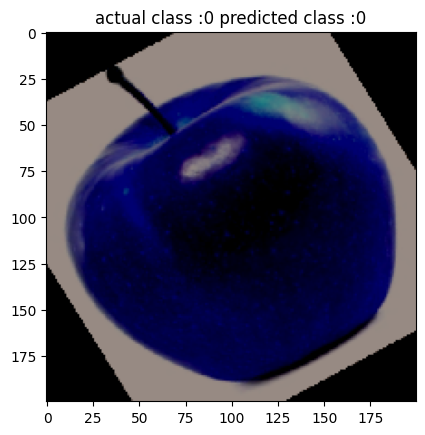

In [75]:
x_batch, y_batch = test_batches.next()
random_index = random.randint(0, len(x_batch))
predictions = model.predict(x_batch[random_index:random_index+1])
predicted_class = np.argmax(predictions[0])
actual_class = np.argmax(y_batch[random_index])
plt.imshow(x_batch[random_index])
plt.title("actual class :"+str(actual_class) + " predicted class :"+str(predicted_class))
plt.show()

### Lite djupare översikt på vad som händer för varje epochs

Epoch 1/10
245/245 [==============================] - 200s 817ms/step - loss: 0.1490 - accuracy: 0.9453 - val_loss: 0.0880 - val_accuracy: 0.9696
Epoch 2/10
245/245 [==============================] - 208s 849ms/step - loss: 0.1041 - accuracy: 0.9634 - val_loss: 0.0554 - val_accuracy: 0.9858
Epoch 3/10
245/245 [==============================] - 212s 864ms/step - loss: 0.0901 - accuracy: 0.9681 - val_loss: 0.0742 - val_accuracy: 0.9748
Epoch 4/10
245/245 [==============================] - 213s 869ms/step - loss: 0.0637 - accuracy: 0.9776 - val_loss: 0.0577 - val_accuracy: 0.9795
Epoch 5/10
245/245 [==============================] - 216s 883ms/step - loss: 0.0724 - accuracy: 0.9758 - val_loss: 0.0585 - val_accuracy: 0.9764
Epoch 6/10
245/245 [==============================] - 223s 911ms/step - loss: 0.0511 - accuracy: 0.9834 - val_loss: 0.0431 - val_accuracy: 0.9869
Epoch 7/10
245/245 [==============================] - 215s 879ms/step - loss: 0.0536 - accuracy: 0.9825 - val_loss: 0.1841 -

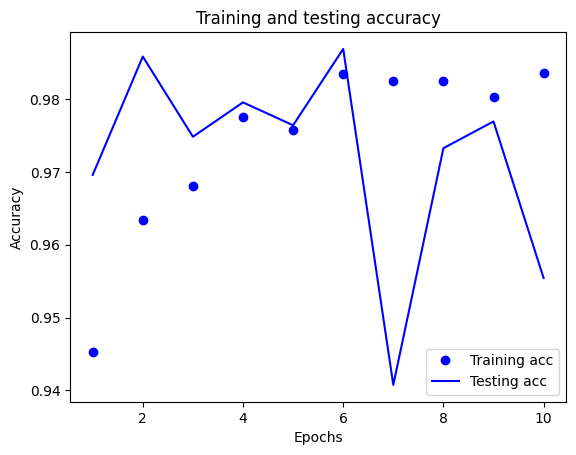

In [76]:
history = model.fit(train_batches, validation_data=test_batches, epochs=10)

# Hämtar info från history 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Plottar datat med olika parametrar
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Testing acc')
plt.title('Training and testing accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Enligt grafen så är 6 epochs det bästa, men något konstigt händer vid 7 epochs så kanske den inte visar helt korrekt men man får testa alla olika sorters parametrar och dukumentera ner dom bästa